# Putting it all together

So far we have done the following on the prior Notebooks:

- **Notebook 01**: We loaded the Azure Search Engine with thousands of files in index: "srch-index-files"
- **Notebook 02**: We loaded more information to the Search Engine this time using a CSV file with 90k rows/articles in index: "srch-index-csv"
- **Notebook 03**: We added AzureOpenAI GPT models to enhance the the production of the answer by using Utility Chains of LLMs
- **Notebook 04**: We manually loaded an index with large/complex PDFs information , "srch-index-books"
- **Notebook 05**: We added memory to our system in order to power a conversational Chat Bot
- **Notebook 06**: We introduced Agents and Graphs and built the first Skill/Agent, that can do RAG over a search engine
- **Notebook 07**: We build a second Agent in order to be able to solve a more complex task: ask questions to Tabular datasets on CSV files
- **Notebook 08**: We build a SQL Agent in order to talk to a SQL Database directly
- **Notebook 09**: We used another  Agent in order to talk to the Bing Search API and create a Copilot Clone
- **Notebook 10**: We built an API Agent that can translate a question into the right API calls, giving us the capability to talk to any datasource that provides a RESTFul API.
- **Notebook 11**: We found out how to add eyes and ears (and mouth) to our system using multi-modal models.


We are missing one more thing: **How do we glue all these features together into a very smart GPT Smart Search Engine Chat Agent?**

We want a virtual assistant for our company that can get the question, think what tool to use, then get the answer. The goal is that, regardless of the source of the information (Search Engine, Bing Search, SQL Database, CSV File, JSON File, APIs, etc), the Smart Agent/Assistant can answer the question correctly using the right tool.

In this Notebook we are going to create a Smart Agent (also called Supervisor Agent), that:

1) understands the user input 
2) talks to other specialized Agents that are connected to diferent tools/sources
3) once it get's the answer it delivers it to the user or let the specialized Agent to deliver it directly

This is an image of the agentic architecture:

![image](https://langchain-ai.github.io/langgraphjs/tutorials/multi_agent/img/supervisor-diagram.png)

In [1]:
import os
import random
import json
import uuid
import requests
import logging
import functools
import operator
from pydantic import BaseModel
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict

from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.serde.jsonplus import JsonPlusSerializer


#custom libraries that we will use later in the app
from common.utils import (
    create_docsearch_agent,
    create_csvsearch_agent,
    create_sqlsearch_agent,
    create_websearch_agent,
    create_apisearch_agent,
    reduce_openapi_spec
)
from common.cosmosdb_checkpointer import CosmosDBSaver, AsyncCosmosDBSaver

from common.prompts import (
    CUSTOM_CHATBOT_PREFIX,
    DOCSEARCH_PROMPT_TEXT,
    CSV_AGENT_PROMPT_TEXT,
    MSSQL_AGENT_PROMPT_TEXT,
    BING_PROMPT_TEXT,
    APISEARCH_PROMPT_TEXT,
    SUPERVISOR_PROMPT_TEXT
)

from dotenv import load_dotenv
load_dotenv("credentials.env")

from IPython.display import Image, Markdown, Audio, display 

from common.audio_utils import text_to_speech 

def play_audio(file_path):
    """Play an audio file in Jupyter Notebook."""
    display(Audio(file_path, autoplay=True))

def printmd(string):
    # Remove ```markdown and ``` from the text
    clean_content = re.sub(r'^```markdown\n', '', string)
    clean_content = re.sub(r'^```\n', '', clean_content)
    clean_content = re.sub(r'\n```$', '', clean_content)

    # Escape dollar signs to prevent LaTeX rendering
    clean_content = clean_content.replace('$', r'\$')
    display(Markdown(clean_content))


In [2]:
# # Get the root logger
# root_logger = logging.getLogger()
# root_logger.setLevel(logging.ERROR)  # Set the root logger level to INFO, ERROR, DEBUG

In [3]:
os.environ["OPENAI_API_VERSION"] = os.environ["AZURE_OPENAI_API_VERSION"]

In [4]:
COMPLETION_TOKENS = 2000

llm = AzureChatOpenAI(deployment_name=os.environ["GPT4o_DEPLOYMENT_NAME"], 
                      temperature=0, max_tokens=COMPLETION_TOKENS, 
                      streaming=True)


### Create the Specialized Agents

**Consider the following concept:** Agents, which are essentially software entities designed to perform specific tasks, can be equipped with tools. These tools themselves can be other agents, each possessing their own set of tools. This creates a layered structure where tools can range from code sequences to human actions, forming interconnected chains. Ultimately, you're constructing a network of agents and their respective tools, all collaboratively working towards solving a specific task (This is what ChatGPT is). This network operates by leveraging the unique capabilities of each agent and tool, creating a dynamic and efficient system for task resolution.

In the file `common/utils.py` we created LangGraph Agents for each of the Functionalities that we developed in prior Notebooks. 

#### **DocSearch Agent**

In [5]:
indexes = ["srch-index-files", "srch-index-csv", "srch-index-books"]
docsearch_agent = create_docsearch_agent(llm,indexes,k=20,reranker_th=1.5,
                                         prompt=CUSTOM_CHATBOT_PREFIX + DOCSEARCH_PROMPT_TEXT,
                                         sas_token=os.environ['BLOB_SAS_TOKEN']
                                        )

#### **CSVSearch Agent**

In [6]:
file_url = "./data/all-states-history.csv"
csvsearch_agent = create_csvsearch_agent(llm,
                                         prompt=CUSTOM_CHATBOT_PREFIX + CSV_AGENT_PROMPT_TEXT.format(file_url=file_url))

#### **SQLSearch Agent**

In [7]:
sqlsearch_agent = create_sqlsearch_agent(llm, 
                                     prompt=CUSTOM_CHATBOT_PREFIX + MSSQL_AGENT_PROMPT_TEXT)

#### **WebSearch Agent**

In [8]:
websearch_agent = create_websearch_agent(llm, 
                                     prompt=CUSTOM_CHATBOT_PREFIX + BING_PROMPT_TEXT)

#### **APISearch Agent**

In [9]:
api_file_path = "./data/openapi_kraken.json"
with open(api_file_path, 'r') as file:
    spec = json.load(file)
    
reduced_api_spec = reduce_openapi_spec(spec)

apisearch_agent = create_apisearch_agent(llm, 
                                     prompt=CUSTOM_CHATBOT_PREFIX + APISEARCH_PROMPT_TEXT.format(api_spec=reduced_api_spec))

### Helper Utilities¶
Define helper functions that we will use to create the nodes in the graph - it takes care of converting the agent response to an AI message. This is important because that is how we will add it the global state of the graph

In [10]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [AIMessage(content=result["messages"][-1].content, name=name)]
    }

async def agent_node_async(state, agent, name):
    result = await agent.ainvoke(state)
    return {
        "messages": [AIMessage(content=result["messages"][-1].content, name=name)]
    }

Define functions to print the events and respond with Audio.

These are two different ways to print and stream the answers and events

In [11]:
# Define a sync function to stream graph updates
def stream_graph_updates_sync(user_input: str, graph, config):
    last_agent_message = ""  # Will hold the latest AIMessage content

    for event in graph.stream({"messages": [("human", user_input)]}, config, stream_mode="updates"):
        print(event)  # Print the raw event

        # Each event is a dict, e.g. {"WebSearchAgent": {...}} or {"supervisor": {"next": "..."}}
        if isinstance(event, dict):
            for key, value in event.items():
                # 1) If this is an agent event, store the latest AIMessage content
                if isinstance(value, dict) and "messages" in value:
                    # The messages are usually a list of AIMessage or similar objects
                    messages = value["messages"]
                    if messages:
                        # Grab the last message
                        last_msg = messages[-1]
                        # If it's an AIMessage, you can get `.content`
                        # Adjust as needed for your data structure
                        last_agent_message = getattr(last_msg, "content", str(last_msg))

                # 2) If supervisor says "next": "FINISH", we've hit the end
                if key == "supervisor":
                    if value.get("next") == "FINISH" and last_agent_message:
                        # This is the final step -> TTS on last_agent_message
                        tts_audio_file = text_to_speech(last_agent_message)
                        if tts_audio_file:
                            play_audio(tts_audio_file)



# Define an async function to stream events async
async def stream_graph_updates_async(user_input: str, graph, config):
    inputs = {"messages": [("human", user_input)]}
    complete_text = ""  # Store the full response text for TTS

    async for event in graph.astream_events(inputs, config, version="v2"):
        if (
            event["event"] == "on_chat_model_stream"  # Ensure the event is a chat stream event
            and event["metadata"].get("langgraph_node") == "agent"
        ):
            # Print the content of the chunk progressively
            chunk_text = event["data"]["chunk"].content
            print(chunk_text, end="", flush=True)
            complete_text += chunk_text  # Accumulate chunks of text

        if (
            event["event"] == "on_tool_start"  
            and event["metadata"].get("langgraph_node") == "tools"  # Ensure it's from the tools node
        ):
            print("\n--")
            print(f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}")
            print("--")
        if (
            event["event"] == "on_tool_end"  # Ensure the event is a chat stream event
            and event["metadata"].get("langgraph_node") == "tools"  # Ensure it's from the chatbot node
        ):
            print("\n--")
            print(f"Done tool: {event['name']}")
            print("--")
            
        if (
            event["event"] == "on_chain_end"
            and event.get("name") == "LangGraph"
        ):
            # Check if the chain truly ended
            output_data = event["data"].get("output", {})
            if output_data.get("next") == "FINISH":
                # Ensure complete_text has the final message
                if complete_text:
                    # Text-to-Speech conversion and playback
                    tts_audio_file = text_to_speech(complete_text)
                    if tts_audio_file:
                        play_audio(tts_audio_file)

    

### State of the Graph
The state is the input to each node in the graph

In [12]:
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


### Create Supervisor Node

In [13]:
members = ["DocSearchAgent", "SQLSearchAgent", "CSVSearchAgent", "WebSearchAgent", "APISearchAgent"]

system_prompt = SUPERVISOR_PROMPT_TEXT

# The supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

# routeResponse is a model class used to represent the structure of the response data. In this case, it acts as a structured output model to ensure that the data being returned or processed matches a specific format.
class routeResponse(BaseModel):
    # The class has one field, next, which specifies the expected type of data for that field.
    # By using Literal[tuple(options)], you are specifying that the next attribute in routeResponse can only take one of the exact values from options. 
    next: Literal[tuple(options)]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}\n.",
        ),
    ]
).partial(options=str(options))


# We will use function calling to choose the next worker node OR finish processing.
def supervisor_node(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

async def supervisor_node_async(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return await supervisor_chain.ainvoke(state)

### Construct the SYNC graph of our application

In [14]:
# By using functools.partial, we are creating a new function where the agent and name arguments are already set
# This approach makes the code more modular and reusable. 
# When you need to call a node , you only need to provide the "state" argument because agent and name are already specified.

docsearch_agent_node = functools.partial(agent_node, agent=docsearch_agent, name="DocSearchAgent")
sqlsearch_agent_node = functools.partial(agent_node, agent=sqlsearch_agent, name="SQLSearchAgent")
csvsearch_agent_node = functools.partial(agent_node, agent=csvsearch_agent, name="CSVSearchAgent")
websearch_agent_node = functools.partial(agent_node, agent=websearch_agent, name="WebSearchAgent")
apisearch_agent_node = functools.partial(agent_node, agent=apisearch_agent, name="APISearchAgent")

workflow = StateGraph(AgentState)
workflow.add_node("DocSearchAgent", docsearch_agent_node)
workflow.add_node("SQLSearchAgent", sqlsearch_agent_node)
workflow.add_node("CSVSearchAgent", csvsearch_agent_node)
workflow.add_node("WebSearchAgent", websearch_agent_node)
workflow.add_node("APISearchAgent", apisearch_agent_node)
workflow.add_node("supervisor", supervisor_node)

# Connect the edges from each member to the supervisor
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")

# Connect the supervisor to the members with a condition
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
# This lambda function acts as the condition that extracts the "next" field from the current state. 
# The add_conditional_edges method then uses this output to check the conditional_map and route the workflow accordingly.
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

### Compile SYNC Graph with CosmosDB as persistent memory

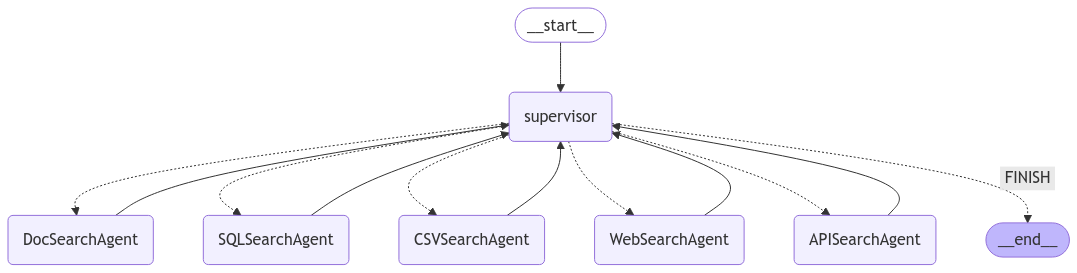

In [15]:
checkpointer_sync = CosmosDBSaver(
    endpoint=os.environ["AZURE_COSMOSDB_ENDPOINT"],
    key=os.environ["AZURE_COSMOSDB_KEY"],
    database_name=os.environ["AZURE_COSMOSDB_NAME"],
    container_name=os.environ["AZURE_COSMOSDB_CONTAINER_NAME"],
    serde=JsonPlusSerializer(),
)

# Manually initialize resources
checkpointer_sync.setup()

# Compile the synchronous graph after setup is complete
graph_sync = workflow.compile(checkpointer=checkpointer_sync)

# Define a test thread_id to store in the persistent storage
config_sync = {"configurable": {"thread_id": str(uuid.uuid4())}}

display(Image(graph_sync.get_graph().draw_mermaid_png()))

### Run SYNC App

In [16]:
# Run the synchronous agent
print("Running the synchronous agent:")
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    try:
        stream_graph_updates_sync(user_input, graph_sync, config_sync)
    except Exception as e:
        print(f"Error during synchronous update: {e}")

Running the synchronous agent:


User:  hey there, I'm Pablo, who are you?


{'supervisor': {'next': 'WebSearchAgent'}}
{'WebSearchAgent': {'messages': [AIMessage(content="Hello Pablo! I'm Jarvis, here to help you find information and answer your questions. How can I assist you today?", additional_kwargs={}, response_metadata={}, name='WebSearchAgent')]}}
{'supervisor': {'next': 'FINISH'}}


User:  @websearch, tell me great EDM night clubs in miami and the next shows this week


{'supervisor': {'next': 'WebSearchAgent'}}
{'WebSearchAgent': {'messages': [AIMessage(content='Here are some great EDM nightclubs in Miami and the upcoming shows this week:\n\n### Top EDM Nightclubs in Miami:\n1. **Club Space** - Known for its outstanding party vibe, located in downtown Miami.\n2. **Do Not Sit on the Furniture** - Offers a unique vibe with deep house music, located on 16th Street.\n3. **E11even** - A 24/7 ultraclub in downtown Miami, known for its immersive nightlife experience.\n4. **Story** - Famous for its uniquely themed events, located on Collins Avenue.\n5. **Rockwell Miami** - Known for hosting celebrities and offering a cool atmosphere.\n6. **Treehouse** - Popular for deep house music, located on 23rd Street.\n7. **LIV** - Located in the historic Fontainebleau Hotel, known for its high-energy dance club atmosphere[[1]](https://www.nightflow.com/edm-clubs-in-miami/)[[2]](https://nox-agency.com/miami/guides/best-edm-clubs-miami).\n\n### Upcoming EDM Shows in Miam

User:  @docseach, is invercmentin good against covid?


{'supervisor': {'next': 'DocSearchAgent'}}
{'DocSearchAgent': {'messages': [AIMessage(content='The current evidence suggests that ivermectin is not likely to be effective against COVID-19 at doses that are safe for human use. Studies have shown that while ivermectin can inhibit SARS-CoV-2 in vitro, the concentrations required to achieve this effect are much higher than what can be safely achieved in humans through oral administration. Specifically, the inhibitory concentrations are not attainable in humans based on available pharmacokinetic data from clinically relevant dosing studies[[1]](https://doi.org/10.1101/2020.04.11.20061804?sv=2022-11-02&ss=b&srt=sco&sp=rltfx&se=2026-01-02T09:04:19Z&st=2025-01-02T01:04:19Z&spr=https&sig=q%2FjY9R25rdc%2BIH1iiq1uPIBm82xECsN9d%2B2ftdM1SJI%3D)[[2]](http://medrxiv.org/cgi/content/short/2020.04.21.20073262v1?rss=1?sv=2022-11-02&ss=b&srt=sco&sp=rltfx&se=2026-01-02T09:04:19Z&st=2025-01-02T01:04:19Z&spr=https&sig=q%2FjY9R25rdc%2BIH1iiq1uPIBm82xECsN9d%2

User:  thank you, you are good!


{'supervisor': {'next': 'FINISH'}}


User:  bye


{'supervisor': {'next': 'FINISH'}}


User:  q


Goodbye!


### Construct the ASYNC graph of our application

In [17]:
docsearch_agent_node_async = functools.partial(agent_node_async, agent=docsearch_agent, name="DocSearchAgent")
sqlsearch_agent_node_async = functools.partial(agent_node_async, agent=sqlsearch_agent, name="SQLSearchAgent")
csvsearch_agent_node_async = functools.partial(agent_node_async, agent=csvsearch_agent, name="CSVSearchAgent")
websearch_agent_node_async = functools.partial(agent_node_async, agent=websearch_agent, name="WebSearchAgent")
apisearch_agent_node_async = functools.partial(agent_node_async, agent=apisearch_agent, name="APISearchAgent")

workflow_async = StateGraph(AgentState)
workflow_async.add_node("DocSearchAgent", docsearch_agent_node_async)
workflow_async.add_node("SQLSearchAgent", sqlsearch_agent_node_async)
workflow_async.add_node("CSVSearchAgent", csvsearch_agent_node_async)
workflow_async.add_node("WebSearchAgent", websearch_agent_node_async)
workflow_async.add_node("APISearchAgent", apisearch_agent_node_async)
workflow_async.add_node("supervisor", supervisor_node_async)

# Connect the edges from each member to the supervisor
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow_async.add_edge(member, "supervisor")

# Connect the supervisor to the members with a condition
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
# This lambda function acts as the condition that extracts the "next" field from the current state. 
# The add_conditional_edges method then uses this output to check the conditional_map and route the workflow accordingly.
workflow_async.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow_async.add_edge(START, "supervisor")

### Let's talk to our GPT Smart Search Engine ASYNC chat bot now

In [18]:
# We can as well avoid the .setup() call of the cosmosDB by using the with statement as below
async def run_async_agent():
    async with AsyncCosmosDBSaver(
        endpoint=os.environ["AZURE_COSMOSDB_ENDPOINT"],
        key=os.environ["AZURE_COSMOSDB_KEY"],
        database_name=os.environ["AZURE_COSMOSDB_NAME"],
        container_name=os.environ["AZURE_COSMOSDB_CONTAINER_NAME"],
        serde=JsonPlusSerializer(),
    ) as checkpointer_async:
        # Compile the asynchronous graph
        graph_async = workflow_async.compile(checkpointer=checkpointer_async)
        # Define a test thread_id to store in the persistent storage
        config_async = {"configurable": {"thread_id": str(uuid.uuid4())}}



        print("\nRunning the asynchronous agent:")
        while True:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye!")
                break
            await stream_graph_updates_async(user_input, graph_async ,config_async)

# Run the asynchronous agent
await run_async_agent()


Running the asynchronous agent:


User:  hey there, who are you


Hello! I'm Jarvis, your AI assistant here to help you with information and answer your questions based on data I can retrieve. How can I assist you today?

User:  @apisearch, tell me the price of bitcoin in euros today



--
Starting tool: requests_get with inputs: {'url': 'https://api.kraken.com/0/public/Ticker?pair=XXBTZEUR'}
--

--
Done tool: requests_get
--
The current price of Bitcoin in Euros (EUR) is approximately €91,504.90.

User:  @sqlsearch, what state on the west coast had more hospitalizations?



--
Starting tool: sql_db_list_tables with inputs: {}
--

--
Done tool: sql_db_list_tables
--

--
Starting tool: sql_db_schema with inputs: {'table_names': 'covidtracking'}
--

--
Done tool: sql_db_schema
--

--
Starting tool: sql_db_query_checker with inputs: {'query': "SELECT state, SUM(hospitalizedCumulative) as total_hospitalizations FROM covidtracking WHERE state IN ('CA', 'OR', 'WA') GROUP BY state ORDER BY total_hospitalizations DESC LIMIT 1"}
--

--
Done tool: sql_db_query_checker
--

--
Starting tool: sql_db_query with inputs: {'query': "SELECT state, SUM(hospitalizedCumulative) as total_hospitalizations FROM covidtracking WHERE state IN ('CA', 'OR', 'WA') GROUP BY state ORDER BY total_hospitalizations DESC LIMIT 1"}
--

--
Done tool: sql_db_query
--

--
Starting tool: sql_db_query_checker with inputs: {'query': "SELECT TOP 1 state, SUM(hospitalizedCumulative) as total_hospitalizations FROM covidtracking WHERE state IN ('CA', 'OR', 'WA') GROUP BY state ORDER BY total_hospitali

User:  q


Goodbye!


# Summary

Great!, We just built the GPT Smart Search Engine! a Multi-Agentic architecture with persistent memory!.

**Note:** To build the apps we built a library `commom/graph.py` that contains all the functions on this notebook that builds an async graph.


We can have many tools or subagents to accomplish different tasks, including connecting to APIs, dealing with File Systems, and even using Humans as Tools. For more reference see [HERE](https://python.langchain.com/docs/integrations/tools/)

# NEXT
It is time now to use all the functions and prompts build so far and build a Web application.
The Next notebook will guide you on how to build:

1) A Bot API Backend
2) A Frontend UI with a Search and Webchat interfaces